# Quick Demos of Statistics and Machine Learning in Python

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
%matplotlib inline

## Dealing with categorical data

In [2]:
np.random.seed(27)
s = pd.Series(np.random.choice(['bad', 'neutral', 'good'], size=40))
s

0         bad
1         bad
2         bad
3         bad
4     neutral
       ...   
35       good
36    neutral
37        bad
38        bad
39    neutral
dtype: object

In [3]:
np.random.seed(27)
s = pd.Series(pd.Categorical(np.random.choice(['bad', 'neutral', 'good'], size=40),
                             categories=['bad', 'neutral', 'good'], ordered=True))
s

0         bad
1         bad
2         bad
3         bad
4     neutral
       ...   
35       good
36    neutral
37        bad
38        bad
39    neutral
dtype: category
Categories (3, object): [bad < neutral < good]

Categoricals can go inside of Series or DataFrames just like any other column. The have a
a special `.cat` namespace.

In [4]:
s.cat.categories

Index([u'bad', u'neutral', u'good'], dtype='object')

In [5]:
s.cat.codes

0     0
1     0
2     0
3     0
4     1
     ..
35    2
36    1
37    0
38    0
39    1
dtype: int8

In [6]:
df = pd.DataFrame({'a': np.arange(40), 'b': s})
df

,a,b
0,0,bad
1,1,bad
2,2,bad
3,3,bad
4,4,neutral
...,...,...
35,35,good
36,36,neutral
37,37,bad
38,38,bad


### Dummy variables

In [7]:
pd.get_dummies(s)

,bad,neutral,good
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
35,0,0,1
36,0,1,0
37,1,0,0
38,1,0,0


In [8]:
kinds = [
    'A|B',
    'A|B|C',
    'C',
    'B|A',
    'A|B'
]
s = pd.Series(kinds)
s

0      A|B
1    A|B|C
2        C
3      B|A
4      A|B
dtype: object

In [9]:
s.str.get_dummies(sep='|')

,A,B,C
0,1,1,0
1,1,1,1
2,0,0,1
3,1,1,0
4,1,1,0


# Statsmodels

Brief primer: you give a **estimator** (OLS, WLS, GLM) a **formula** and **dataset**. You then fit that model.

In [10]:
import statsmodels.api as sm

We've got some longintudinal data (repeated measures of the same individual on children with HIV). 

There are two treatment arms (ARV vs control) represented by `treatment`, and administration of the treatment is indicated by `arv`.

In [11]:
df = pd.read_csv('../data/random/cd4.csv', parse_dates=['VDATE'], index_col=['newpid', 'VISIT'])
df = df.dropna()  # estimator can't handle NaNs so ignore for now.
df.head()

VDATE  CD4PCT  arv  treatmnt  CD4CNT  baseage
newpid VISIT                                                   
1      1     1988-06-29    18.0  0.0         1   323.0     3.91
       4     1989-01-19    37.0  0.0         1   610.0     3.91
       7     1989-04-13    13.0  0.0         1   324.0     3.91
       13    1989-11-30    13.0  0.0         1   626.0     3.91
       19    1990-06-07    12.0  1.0         1   220.0     3.91

Some basic statistics:

In [12]:
df.groupby(['arv', 'treatmnt'])['CD4PCT'].count().unstack()

treatmnt,1,2
arv,,
0.0,486,402
1.0,48,42


In [13]:
df.groupby('arv')['CD4CNT'].mean()

arv
0.0    947.930180
1.0    926.166667
Name: CD4CNT, dtype: float64

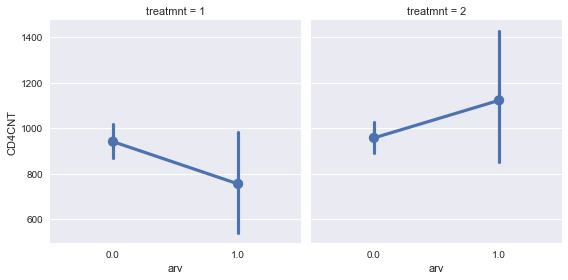

In [14]:
sns.factorplot(x='arv', y='CD4CNT', col='treatmnt', data=df)

In [15]:
df.head()

VDATE  CD4PCT  arv  treatmnt  CD4CNT  baseage
newpid VISIT                                                   
1      1     1988-06-29    18.0  0.0         1   323.0     3.91
       4     1989-01-19    37.0  0.0         1   610.0     3.91
       7     1989-04-13    13.0  0.0         1   324.0     3.91
       13    1989-11-30    13.0  0.0         1   626.0     3.91
       19    1990-06-07    12.0  1.0         1   220.0     3.91

In [16]:
years_since = df.groupby(level='newpid')['VDATE']\
    .apply(lambda x: (x - x.min()).dt.days / 365)
df['age'] = df['baseage'] + years_since

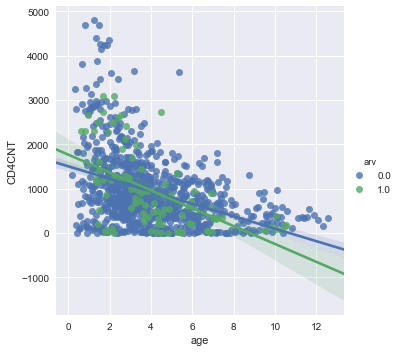

In [17]:
sns.lmplot('age', 'CD4CNT', data=df, hue="arv")

### Linear regression

In [18]:
mod = sm.GLM.from_formula('CD4PCT ~ age + arv + treatmnt', df.reset_index())
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 CD4PCT   No. Observations:                  978
Model:                            GLM   Df Residuals:                      974
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                   171.820106367
Method:                          IRLS   Log-Likelihood:                -3902.3
Date:                Wed, 25 Oct 2017   Deviance:                   1.6735e+05
Time:                        23:40:30   Pearson chi2:                 1.67e+05
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.9086      1.495     15.996      0.000      20.979      26.838
age           -0.9923      0.183     -5.421      0.000      -1.351      -0.634
arv            1.6919      1.451      1.166      0.243      -1.151       4.535
treatmnt       2.7020      0.842      3.209      0.001       1.052       4.352
==============================================================================
"""

### Mixed effects models

In [19]:
mod2 = sm.MixedLM.from_formula('CD4PCT ~ age + arv*treatmnt', df.reset_index(), groups='newpid')
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: CD4PCT    
No. Observations: 978     Method:             REML      
No. Groups:       226     Scale:              50.9117   
Min. group size:  1       Likelihood:         -3569.4486
Max. group size:  7       Converged:          Yes       
Mean group size:  4.3                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     27.323    2.733  9.998 0.000 21.967 32.679
age           -1.799    0.305 -5.908 0.000 -2.396 -1.202
arv            4.760    3.129  1.521 0.128 -1.373 10.892
treatmnt       2.128    1.613  1.320 0.187 -1.032  5.289
arv:treatmnt  -1.955    2.056 -0.951 0.342 -5.985  2.075
groups RE    128.092    2.236                           
========================================================

"""

# Exercise
1. Use a linear regression to find the relationship between SDI and the death rate in 1 to 4 year olds
2. What happens if you use a random effect on `location_id` to adjust for differences between countries?
3. Are we just picking up a time effect? What happens if you add year to the model?

In [20]:
data = pd.read_hdf('../data/processed/gbd_1to4_deaths_and_sdi.hdf')
data.head()

death_rate       sdi
location_id year_id                      
6           1990       0.003253  0.733148
            1991       0.003092  0.739537
            1992       0.002907  0.745751
            1993       0.002722  0.751388
            1994       0.002550  0.756424

In [21]:
lm = sm.GLM.from_formula('death_rate ~ sdi', data)
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             death_rate   No. Observations:                 5076
Model:                            GLM   Df Residuals:                     5074
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:               1.64598950454e-05
Method:                          IRLS   Log-Likelihood:                 20753.
Date:                Wed, 25 Oct 2017   Deviance:                     0.083518
Time:                        23:40:32   Pearson chi2:                   0.0835
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0258      0.000    107.405      0.000       0.025       0.026
sdi           -0.0303      0.000    -92.019      0.000      -0.031      -0.030
==============================================================================
"""

In [22]:
mixed = sm.MixedLM.from_formula('death_rate ~ sdi', data.reset_index(), groups='location_id')
mixed.fit().summary()

/Users/kfor/.conda/envs/forecast-2-fork/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: death_rate
No. Observations: 5076    Method:             REML      
No. Groups:       188     Scale:              0.0000    
Min. group size:  27      Likelihood:         23864.8957
Max. group size:  27      Converged:          Yes       
Mean group size:  27.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.032    0.001  61.857 0.000  0.031  0.033
sdi          -0.038    0.001 -63.736 0.000 -0.040 -0.037
groups RE     0.000    0.001                            
========================================================

"""

In [23]:
mixed_with_year = sm.MixedLM.from_formula('death_rate ~ sdi + year_id', data.reset_index(), groups='location_id')
mixed_with_year.fit().summary()

/Users/kfor/.conda/envs/forecast-2-fork/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: death_rate
No. Observations: 5076    Method:             REML      
No. Groups:       188     Scale:              0.0000    
Min. group size:  27      Likelihood:         23853.8296
Max. group size:  27      Converged:          Yes       
Mean group size:  27.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.033    0.012   2.669 0.008  0.009  0.057
sdi          -0.038    0.001 -35.767 0.000 -0.040 -0.036
year_id      -0.000    0.000  -0.104 0.917 -0.000  0.000
groups RE     0.000    0.001                            
========================================================

"""

# Scikit-Learn

### Gigantic library of many different kinds of ML and Statistical models

#### [Geospatial SVM example](http://scikit-learn.org/stable/auto_examples/applications/plot_species_distribution_modeling.html)

Automatically created module for IPython interactive environment


________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... 
done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... 
done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 55.57s


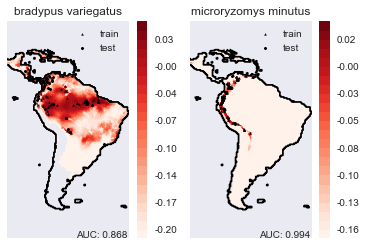

In [24]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ")
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)[:, 0]
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean)
                                          / std)[:, 0]
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

## [Tensorflow](https://www.tensorflow.org/)

Google's latest ML library

Also see [TF-Slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)

In [25]:
from IPython import display
display.HTML('<iframe src="http://playground.tensorflow.org/" height=500 width=1024>')

Slide materials adapted from [Tom Augspurger](https://github.com/TomAugspurger/pydata-chi-h2t/blob/master/6-StatsAndML.ipynb)